# Assignment 01: Multi-class Classification 
In this Assignment, you will train a deep model on the CIFAR10 from the scratch using PyTorch.

### Basic Imports

In [1]:
from sklearn.metrics import f1_score
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
from PIL import Image

### Hyperparameters

In [2]:
# random seed
SEED = 1 
NUM_CLASS = 10

# Training
BATCH_SIZE = 64
NUM_EPOCHS = 150
EVAL_INTERVAL=1
SAVE_DIR = './log'

# Optimizer
LEARNING_RATE = 1e-4
MOMENTUM = 0.9
STEP=5
GAMMA=0.5


### Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"


### Dataset


In [4]:
# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = train_set.classes


Files already downloaded and verified
Files already downloaded and verified


### Model

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.dropout1 = nn.Dropout(0.5)
        self.relu4 = nn.ReLU()
        
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool(self.relu3(self.bn3(self.conv3(x))))
        
        x = x.view(-1, 64 * 4 * 4)
        
        x = self.relu4(self.dropout1(self.fc1(x)))
        x = self.fc2(x)
        return x


In [7]:
model = ConvNet()
model.to(device)

ConvNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (relu4): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

### Optimizer

In [8]:
#optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)
from torch.optim import lr_scheduler

# 定义warm-up学习率调度器
def warmup_lr_scheduler(optimizer, warmup_epochs, multiplier):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return (multiplier - 1.0) * epoch / warmup_epochs + 1.0
        return 1.0

    return lr_scheduler.LambdaLR(optimizer, lr_lambda)

# 在训练代码中引入warm-up学习率调度器
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
warmup_epochs = NUM_EPOCHS//5
multiplier = 10
scheduler = warmup_lr_scheduler(optimizer, warmup_epochs, multiplier)

### Task 1: per batch training/testing
---

Please denfine two function named ``train_batch`` and ``test_batch``. These functions are essential for training and evaluating machine learning models using batched data from dataloaders.

**To do**: 
1. Define the loss function i.e [nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).
2. Take the image as the input and generate the output using the pre-defined SimpleNet.
3. Calculate the loss between the output and the corresponding label using the loss function.

In [9]:
def train_batch(model, image, target):

    output = model(image)
    loss = criterion(output, target)

    return output, loss

In [10]:

criterion = nn.CrossEntropyLoss()


def one_hot_encoding(target, num_classes):
    return F.one_hot(target, num_classes=num_classes).float()




In [11]:
def test_batch(model, image, target):

    output = model(image)
    loss = criterion(output, target)
        
    return output, loss

### Model Training

In [12]:
training_loss = []
training_acc = []
testing_loss = []
testing_acc = []
start_time = time.time()  # 记录开始时间
all_preds = []
all_targets = []
# 日志文件
log_file = 'training_log.txt'
for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)
        #######################
        # 为使用L1loss function：
       # target_one_hot = one_hot_encoding(target, 10)  # 转换成 one-hot 编码


        # train model
       # outputs, loss = train_batch(model, image, target_one_hot)  # 使用 one-hot 编码后的目标
        
        outputs, loss = train_batch(model, image, target)
        #########################
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    
    #########
    all_preds.extend(preds.cpu().numpy())
    all_targets.extend(target.cpu().numpy())
    f1 = f1_score(all_targets, all_preds, average='weighted')
    print(f"f1 score in {epoch}th epoch is {f1}")

############
    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            ##################
          #  target_one_hot = one_hot_encoding(target, 10)  # 转换成 one-hot 编码
            outputs, loss = test_batch(model, image, target)
          #  outputs, loss = test_batch(model, image, target_one_hot)  # 使用 one-hot 编码后的目标
            #######################
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())
    with open(log_file, 'a') as f:
        f.write(f'Epoch {epoch+1}/{NUM_EPOCHS}\n')
        f.write(f'Train Accuracy: {epoch_acc:.4f}%\n')
        f.write(f'Test Accuracy: {val_acc:.4f}%\n')
        f.write('\n')

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))
            
end_time = time.time()  # 记录结束时间
duration = end_time - start_time  # 计算训练时间
print(f"训练模型用时：{duration}秒")


Epoch: 1/150 Train Loss: 0.0339 Acc: 0.2084
f1 score in 0th epoch is 0.15416666666666665
Begin test......
Test Loss: 0.0309 Acc: 0.3442
Epoch: 2/150 Train Loss: 0.0299 Acc: 0.3037
f1 score in 1th epoch is 0.34077380952380953
Begin test......
Test Loss: 0.0274 Acc: 0.4077
Epoch: 3/150 Train Loss: 0.0272 Acc: 0.3618
f1 score in 2th epoch is 0.32154528478057887
Begin test......
Test Loss: 0.0248 Acc: 0.4509
Epoch: 4/150 Train Loss: 0.0253 Acc: 0.4071
f1 score in 3th epoch is 0.31261101031321614
Begin test......
Test Loss: 0.0232 Acc: 0.4821
Epoch: 5/150 Train Loss: 0.0239 Acc: 0.4448
f1 score in 4th epoch is 0.30334058302808303
Begin test......
Test Loss: 0.0219 Acc: 0.5088
Epoch: 6/150 Train Loss: 0.0227 Acc: 0.4728
f1 score in 5th epoch is 0.3556777220457561
Begin test......
Test Loss: 0.0207 Acc: 0.5304
Epoch: 7/150 Train Loss: 0.0216 Acc: 0.5029
f1 score in 6th epoch is 0.3766773273682789
Begin test......
Test Loss: 0.0200 Acc: 0.5509
Epoch: 8/150 Train Loss: 0.0207 Acc: 0.5261
f1 sco

### Task 2: Instance inference
---
The task is to visualizes an image along with model prediction and class probabilities.

**To do**: 
1. Calculate the prediction and the probabilities for each class.
         

In [13]:
inputs, classes = next(iter(test_dataloader))
input = inputs[0]

In [14]:
##################### Write your answer here ##################
# input: image, model
# outputs: predict_label, probabilities
# predict_label is the index (or label) of the class with the highest probability from the probabilities.
###############################################################
input_tensor = input.unsqueeze(0).to(device)
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    probabilities = F.softmax(output, dim=1)
    predict_label = torch.argmax(probabilities)
# predict_label = 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


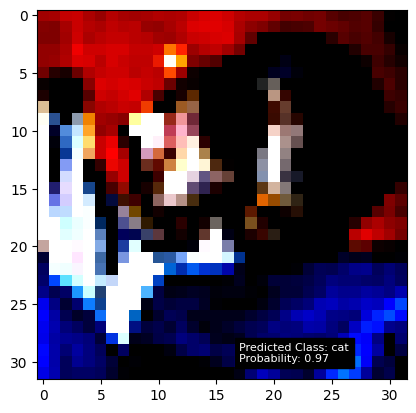

Print probabilities for each class:
airplane: 0.0001
automobile: 0.0000
bird: 0.0002
cat: 0.9748
deer: 0.0001
dog: 0.0239
frog: 0.0003
horse: 0.0002
ship: 0.0003
truck: 0.0001


In [15]:
predicted_class = class_names[predict_label.item()]
predicted_probability = probabilities[0][predict_label.item()]
image = input.numpy().transpose((1, 2, 0))
plt.imshow(image)
plt.text(17, 30, f'Predicted Class: {predicted_class}\nProbability: {predicted_probability:.2f}', 
            color='white', backgroundcolor='black', fontsize=8)
plt.show()

# Print probabilities for each class
print('Print probabilities for each class:')
for i in range(len(class_names)):
    print(f'{class_names[i]}: {probabilities[0][i].item():.4f}')

In [16]:
for i in np.array(training_acc):
    print(f"{i:.5f}",end=',')
print("\n\n")
for i in np.array(testing_acc):
    print(f"{i:.5f}",end=',')

0.20844,0.30368,0.36178,0.40706,0.44480,0.47278,0.50292,0.52614,0.54916,0.56924,0.59030,0.60876,0.62570,0.63890,0.65120,0.66482,0.67402,0.68378,0.69200,0.70184,0.70610,0.71620,0.72168,0.72972,0.73322,0.74014,0.74544,0.74904,0.75370,0.75956,0.78750,0.79212,0.79152,0.79540,0.79650,0.79888,0.79988,0.79926,0.79898,0.80212,0.80360,0.80282,0.80586,0.80420,0.80670,0.80866,0.80516,0.80856,0.80796,0.80864,0.81048,0.81036,0.81246,0.81394,0.81162,0.81308,0.81620,0.81490,0.81592,0.81714,0.81806,0.81744,0.81716,0.82064,0.81816,0.82074,0.82138,0.82442,0.82506,0.82382,0.82532,0.82270,0.82508,0.82506,0.82754,0.82714,0.82988,0.82906,0.82916,0.82950,0.83294,0.83120,0.83178,0.83250,0.83256,0.83186,0.83396,0.83540,0.83388,0.83548,0.83518,0.83880,0.83814,0.84032,0.83846,0.84042,0.83968,0.84176,0.84208,0.84020,0.84180,0.84284,0.84198,0.84330,0.84350,0.84544,0.84452,0.84554,0.84618,0.84616,0.84962,0.84920,0.84874,0.84828,0.84982,0.85008,0.84998,0.85228,0.85024,0.85308,0.85220,0.85372,0.85544,0.85594,0.85460,